In [1]:
# =============================================================================
# Aplicar imputación
# =============================================================================
from classes.DuckDB_Helper_v02 import DuckDBHelper 
from classes.Tronaduras_File_Reader_v03 import TronadurasFileReader
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

#╭──────────────────────────────────────────────────────╮
#| Preprocesamiento de datos                            | 
#╰──────────────────────────────────────────────────────╯
# 📌 Nombre de la base de datos DuckDB
DB_NAME = "data/Tronaduras_vs_Sismicidad.db"
SCHEMA_NAME = "Raw_Data"
CONJUNTO_ESPECIFICO = "Tronaduras"

# 🔗 Instanciar y conectar
db_helper = DuckDBHelper(DB_NAME)

# Instanciar la clase de lectura de tronaduras
Tronaduras_Reader = TronadurasFileReader()

# Leer la tabla completa Raw_Data.Tronaduras usando la clase DuckDBHelper
df_sismicidad = db_helper.select_df(table="Sismicidad",  schema="Raw_Data")

# Leer la tabla completa Raw_Data.Tronaduras usando la clase DuckDBHelper
df_tronaduras = db_helper.select_df(table="Tronaduras",  schema="Raw_Data")


#╭──────────────────────────────────────────────────────────────╮
#| Completar datos faltantes o imputación a la Tabla Tronaduras | 
#╰──────────────────────────────────────────────────────────────╯
# 🔍 Leer estrategias de imputacion
strategies_df = db_helper.select_df(
    table="Variables_Description",
    columns='"Variable", "Imputacion", "Defecto"',
    where=f'Conjunto = \'{CONJUNTO_ESPECIFICO}\'',  # 🔥 Filtra por conjunto
    schema=SCHEMA_NAME
)

# Aplicar la imputación
df_tronaduras = Tronaduras_Reader.impute_df(df=df_tronaduras, strategies_df=strategies_df)


#╭──────────────────────────────────────────────────────────────────────────╮
#| Crear nuevas variables de la tabla Sismicidad:                           |
#| Energia y Momento Sismico(Mo) Acumulados                                 |
#╰──────────────────────────────────────────────────────────────────────────╯

# Ejemplo de columna de Momento Sísmico (ajusta la fórmula a tu caso)
df_sismicidad['Mo'] = 10 ** ((3/2) * (df_sismicidad['Local Magnitude'] + 6.1))


#╭────────────────────────────────────────────────────────────────────╮
#| Relacionar la tabla Tronaduras con la tabla Sismicidad             |
#|    Crear una tabla de relación entre ambas tablas usando:          |
#|    - "Date Time": Fecha y hora de la tronadura y evento sísmico    |
#|       posterior a la fechas de tronadura y antes de la fecha de    |
#|        la siguiente tronadura o un rango de tiempo definido.       |
#╰────────────────────────────────────────────────────────────────────╯

# Crear nuevas columnas para almacenar el N° Disparo de las Tronaduras y su Date Time en df_sismicidad
hours_after = 0 # Valor 0: no se considera el rango de tiempo, Valor 'automatic': se calcula automáticamente
df_sismicidad_con_disparo = df_sismicidad.copy()
df_sismicidad_con_disparo['N° Disparo'] = None
df_sismicidad_con_disparo['Disparo - Date Time'] = None


deltas_calculados = []
# Iterar por cada disparo en df_tronadura para asignar los rangos
for i in range(len(df_tronaduras) - 1): 
    disparo_actual = df_tronaduras.loc[i, 'N° Disparo']
    fecha_inicio = df_tronaduras.loc[i, 'Fecha']
    fecha_fin = fecha_inicio + pd.Timedelta(hours=hours_after) if hours_after>0 else df_tronaduras.loc[i + 1, 'Fecha']
    
    # Calcular el delta entre fecha_inicio y fecha_fin (en horas)
    delta = (fecha_fin - fecha_inicio)
    deltas_calculados.append(delta)

    # Filtrar los valores en df_sismicidad que están dentro del rango
    mask = (df_sismicidad_con_disparo['Date Time'] >= fecha_inicio) & (df_sismicidad_con_disparo['Date Time'] < fecha_fin)
    n_eventos = len(df_sismicidad_con_disparo.loc[mask])
    df_sismicidad_con_disparo.loc[mask, 'N° Disparo'] = disparo_actual
    df_sismicidad_con_disparo.loc[mask, 'Disparo - Date Time'] = fecha_inicio


    print(f"\t 🕒 {disparo_actual} -> Delta: {fecha_inicio} - {fecha_fin}: {int(delta.total_seconds()/3600)} hrs. - "+
      f" Numero de eventos: {n_eventos}")
print(f"⏲ Delta max: {int(max(deltas_calculados).total_seconds()/3600)} hrs. \t |"+
      f" Delta min: {int(min(deltas_calculados).total_seconds()/3600)}hrs. \t |"+
      f" Delta promedio: {int(np.mean(deltas_calculados).total_seconds()/3600)} hrs.")

# Mover las columnas 'N° Disparo' y 'Disparo Date Time' al inicio
columns_order = ['N° Disparo', 'Disparo - Date Time'] + [col for col in df_sismicidad_con_disparo.columns if col not in ['N° Disparo', 'Disparo - Date Time']]
df_sismicidad_con_disparo = df_sismicidad_con_disparo[columns_order]
df_sismicidad_con_disparo.rename(columns={'Date Time': 'Sismicidad - Date Time'}, inplace=True)

# Eliminar las filas que no tienen N° Disparo asignado
df_sismicidad_con_disparo = df_sismicidad_con_disparo.dropna(subset=['N° Disparo']).reset_index(drop=True)


INFO:root:Conectado a data/Tronaduras_vs_Sismicidad.db


✅ Datos leídos desde 'Raw_Data.Sismicidad' y convertidos a DataFrame.
✅ Datos leídos desde 'Raw_Data.Tronaduras' y convertidos a DataFrame.
✅ Datos leídos desde 'Raw_Data.Variables_Description' y convertidos a DataFrame.
🗑️  1 filas eliminadas donde 'N° Disparo' era NaN o vacío.
✅ Columna 'N° Disparo' procesada correctamente.
✅ Columna 'Fecha' procesada correctamente.
❌ Columna 'Hora' no encontrada en el DataFrame, se omite.
✅ Columna 'PK' procesada correctamente.
✅ Columna 'Cobertura Total' procesada correctamente.
✅ Columna 'Cobertura Primario' procesada correctamente.
✅ Columna 'Tronadura_Largo de Perforación (m)' procesada correctamente.
✅ Columna 'Tronadura_N° Tiros' procesada correctamente.
✅ Columna 'Tronadura_N° Tiros Real' procesada correctamente.
✅ Columna 'Tronadura_Kg. de explosivos tronadura' procesada correctamente.
✅ Columna 'Tronadura_Tipo Explosivo' procesada correctamente.
✅ Columna 'Destressing_Se realizó' procesada correctamente.
✅ Columna 'Destressing_N° Tiros' pro

In [2]:
# Calcular Mo acumulado por disparo
df_sismicidad_con_disparo["Mo_cumulative"] = (
    df_sismicidad_con_disparo.groupby("N° Disparo")["Mo"].transform("sum")
)

# Calcular la energía acumulada por disparo
df_sismicidad_con_disparo["Energy_cumulative"] = (
    df_sismicidad_con_disparo.groupby("N° Disparo")["Energy [J]"].transform("sum")
)

# Aqui hay que calcular el Mo y la Energía acumulada incremental por disparo
# Calcular Mo acumulado incremental por disparo
# df_sismicidad_con_disparo["Mo_incremental"]


# Calcular tabla unificada de datos de tronaduras y sismicidad
df_sismicidad_con_disparo['-'] = '-'

df_sismicidad_con_disparo["Mo_incremental"] = (
    df_sismicidad_con_disparo.groupby("N° Disparo")["Mo"].cumsum()
)


# Definir el orden deseado para las columnas prioritarias
columnas_prioritarias = [
    "N° Disparo",
    "Disparo - Date Time",
    "Sismicidad - Date Time",
    "Mo",
    "Mo_incremental"  # Asegúrate de que el nombre coincide
]

# Obtener el resto de las columnas, excluyendo las prioritarias
columnas_restantes = [col for col in df_sismicidad_con_disparo.columns if col not in columnas_prioritarias]

# Reordenar el DataFrame
df_sismicidad_con_disparo = df_sismicidad_con_disparo[columnas_prioritarias + columnas_restantes]




db_helper.close_connection()

🔌 Conexión cerrada manualmente.


In [3]:
# Crea el diccionario con N° Disparo como clave y lista de Mo_incremental como valor
mo_incremental_dict = (
    df_sismicidad_con_disparo
    .groupby("N° Disparo")["Mo_incremental"]
    .apply(list)
    .to_dict()
)

In [4]:
import plotly.graph_objects as go

# Crear figura
fig = go.Figure()

# Agregar una línea por cada disparo
for disparo, mo_lista in mo_incremental_dict.items():
    fig.add_trace(go.Scatter(
        x=list(range(len(mo_lista))),  # índice del evento dentro del disparo
        y=mo_lista,
        mode='lines',
        name=f'Disparo {disparo}'
    ))

# Personalizar layout
fig.update_layout(
    title='Mo incremental por evento dentro de cada disparo',
    xaxis_title='Índice del evento dentro del disparo',
    yaxis_title='Mo incremental',
    showlegend=True,
    template='plotly_white'
)

# Mostrar gráfico
fig.show()


In [5]:

mo_incremental_escalado = {
    disparo: [x / lista[-1] if lista[-1] != 0 else 0 for x in lista]
    for disparo, lista in mo_incremental_dict.items()
}

fig = go.Figure()

for disparo, mo_lista in mo_incremental_escalado.items():  # puedes cambiar a mo_dict_normalizado o mo_dict_zscore
    fig.add_trace(go.Scatter(
        x=list(range(len(mo_lista))),
        y=mo_lista,
        mode='lines',
        name=f'Disparo {disparo}'
    ))

fig.update_layout(
    title='Mo incremental normalizado (curvas comparables)',
    xaxis_title='Índice del evento dentro del disparo',
    yaxis_title='Mo acumulado (normalizado)',
    showlegend=True,
    template='plotly_white'
)

fig.show()

In [6]:
import plotly.graph_objects as go

# Normalización Min-Max por disparo
mo_incremental_normalizado = {}

for disparo, lista in mo_incremental_dict.items():
    if not lista:
        mo_incremental_normalizado[disparo] = []
        continue

    minimo = min(lista)
    maximo = max(lista)

    if maximo != minimo:
        normalizado = [(x - minimo) / (maximo - minimo) for x in lista]
    else:
        normalizado = [0 for _ in lista]  # curva plana, se asigna 0

    mo_incremental_normalizado[disparo] = normalizado



fig = go.Figure()

for disparo, mo_lista in mo_incremental_normalizado.items():
    fig.add_trace(go.Scatter(
        x=list(range(len(mo_lista))),
        y=mo_lista,
        mode='lines',
        name=f'Disparo {disparo}'
    ))

fig.update_layout(
    title='Mo incremental normalizado Min-Max (curvas comparables)',
    xaxis_title='Índice del evento dentro del disparo',
    yaxis_title='Mo acumulado (normalizado 0–1)',
    showlegend=True,
    template='plotly_white'
)

fig.show()


In [7]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import pandas as pd

# Modelos a probar
def modelo_lineal(x, a, b): return a * x + b
def modelo_log(x, a, b): return a * np.log(x + 1) + b
def modelo_exp(x, a, b): return a * np.exp(b * x)

# Diccionario donde guardar resultados
resultados_ajuste = []

# Aplicar a cada curva
#for disparo, y_vals in mo_incremental_escalado.items():
for disparo, y_vals in mo_incremental_normalizado.items():

    x_vals = np.arange(len(y_vals))
    y_vals = np.array(y_vals)

    modelos = {
        "lineal": (modelo_lineal, None),
        "log": (modelo_log, None),
        "exp": (modelo_exp, None),
    }

    errores = {}

    for nombre, (modelo, _) in modelos.items():
        try:
            # Ajustar
            popt, _ = curve_fit(modelo, x_vals, y_vals, maxfev=10000)
            y_pred = modelo(x_vals, *popt)
            error = mean_squared_error(y_vals, y_pred)
            errores[nombre] = (error, popt)
        except Exception:
            errores[nombre] = (np.inf, None)

    # Elegir mejor modelo
    mejor_modelo = min(errores, key=lambda k: errores[k][0])
    error_mejor = errores[mejor_modelo][0]
    coef_mejor = errores[mejor_modelo][1]

    resultados_ajuste.append({
        "N° Disparo": disparo,
        "Mejor Modelo": mejor_modelo,
        "Error MSE": error_mejor,
        "Coeficientes": coef_mejor
    })

# Convertir a DataFrame para análisis
df_resultados_modelos = pd.DataFrame(resultados_ajuste)


d:\Investigacion_Proyectos\Proyectos\Tronaduras y Sismicidad - Teniente\Python\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1017: RuntimeWarning:

overflow encountered in square

d:\Investigacion_Proyectos\Proyectos\Tronaduras y Sismicidad - Teniente\Python\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1055: RuntimeWarning:

invalid value encountered in multiply

d:\Investigacion_Proyectos\Proyectos\Tronaduras y Sismicidad - Teniente\Python\.venv\Lib\site-packages\sklearn\metrics\_regression.py:570: RuntimeWarning:

overflow encountered in square

d:\Investigacion_Proyectos\Proyectos\Tronaduras y Sismicidad - Teniente\Python\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1017: RuntimeWarning:

overflow encountered in square

d:\Investigacion_Proyectos\Proyectos\Tronaduras y Sismicidad - Teniente\Python\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1055: RuntimeWarning:

invalid value encountered in multiply

d:\Investigacion_Proyectos\Proyectos\Tronadura

<Axes: title={'center': 'Distribución de formas de Mo_incremental'}, xlabel='Mejor Modelo'>

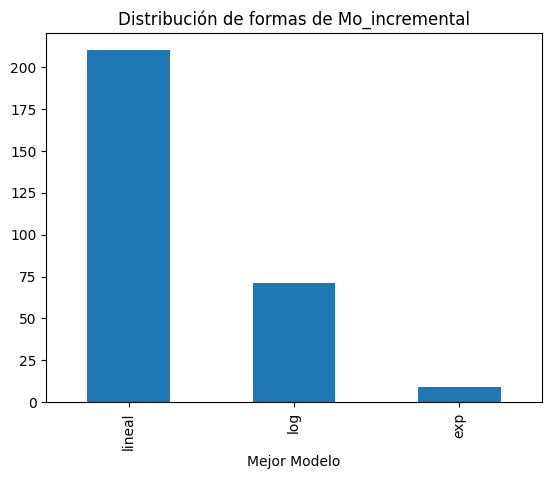

In [8]:
df_resultados_modelos["Mejor Modelo"].value_counts().plot(kind='bar', title="Distribución de formas de Mo_incremental")


In [9]:
import plotly.graph_objects as go
import numpy as np

# Reutilizar las funciones usadas en el ajuste
def modelo_lineal(x, a, b): return a * x + b
def modelo_log(x, a, b): return a * np.log(x + 1) + b
def modelo_exp(x, a, b): return a * np.exp(b * x)

# Diccionario con funciones
modelos = {
    "lineal": modelo_lineal,
    "log": modelo_log,
    "exp": modelo_exp
}

# Crear figura
fig = go.Figure()

# Graficar cada disparo con su curva ajustada
for _, fila in df_resultados_modelos.iterrows():
    disparo = fila["N° Disparo"]
    modelo_nombre = fila["Mejor Modelo"]
    coef = fila["Coeficientes"]

    # Validar que exista la curva real
    if disparo not in mo_incremental_escalado or coef is None:
        continue

    y_real = mo_incremental_escalado[disparo]
    x_vals = np.arange(len(y_real))

    try:
        # Calcular curva ajustada
        y_pred = modelos[modelo_nombre](x_vals, *coef)

        # Agregar al gráfico
        fig.add_trace(go.Scatter(
            x=x_vals,
            y=y_pred,
            mode='lines',
            name=f'Disparo {disparo} ({modelo_nombre})',
            line=dict(width=1)
        ))

    except Exception as e:
        print(f"⚠️ Error al graficar disparo {disparo}: {e}")

# Layout del gráfico
fig.update_layout(
    title="Curvas de regresión ajustadas (superpuestas)",
    xaxis_title="Índice del evento dentro del disparo",
    yaxis_title="Mo incremental ajustado (escalado)",
    showlegend=False,  # Activa si quieres ver etiquetas por disparo
    template="plotly_white"
)

fig.show()


In [10]:
import plotly.graph_objects as go
import numpy as np

# Funciones modelo
def modelo_lineal(x, a, b): return a * x + b
def modelo_log(x, a, b): return a * np.log(x + 1) + b
def modelo_exp(x, a, b): return a * np.exp(b * x)

# Mapeo de nombres a funciones
modelos = {
    "lineal": modelo_lineal,
    "log": modelo_log,
    "exp": modelo_exp
}

# Mapeo de colores por modelo
colores_por_modelo = {
    "lineal": "green",
    "log": "blue",
    "exp": "red"
}

# Crear figura Plotly
fig = go.Figure()

# Agregar trazos
for _, fila in df_resultados_modelos.iterrows():
    disparo = fila["N° Disparo"]
    modelo_nombre = fila["Mejor Modelo"]
    coef = fila["Coeficientes"]

    if disparo not in mo_incremental_escalado or coef is None:
        continue

    y_real = mo_incremental_escalado[disparo]
    x_vals = np.arange(len(y_real))

    try:
        y_pred = modelos[modelo_nombre](x_vals, *coef)
        fig.add_trace(go.Scatter(
            x=x_vals,
            y=y_pred,
            mode='lines',
            line=dict(color=colores_por_modelo.get(modelo_nombre, "gray"), width=1),
            name=f'Disparo {disparo} ({modelo_nombre})',
            legendgroup=modelo_nombre,
            showlegend=False  # evitamos duplicados; activaremos uno por tipo luego
        ))
    except Exception as e:
        print(f"⚠️ Error al graficar disparo {disparo}: {e}")

# Añadir una curva dummy por grupo para mostrar leyenda solo una vez
for modelo, color in colores_por_modelo.items():
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color=color),
        name=f"Modelo: {modelo}",
        showlegend=True
    ))

# Layout
fig.update_layout(
    title="Curvas de regresión ajustadas por tipo de modelo",
    xaxis_title="Índice del evento dentro del disparo",
    yaxis_title="Mo incremental ajustado (escalado)",
    template="plotly_white"
)

fig.show()
